# Classificação de Sinais de Qualidade de Energia com CNN 1D

Rede neural convolucional 1D para classificar 16 tipos de distúrbios elétricos.

## 1. Importar Bibliotecas

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU disponível: []


## 2. Carregar Dataset

In [2]:
# Carregar dataset
# with open('dataset/complete_dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)

with open('data\power_quality_signals\complete_dataset_stratified.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Filtrar primeiras 9 classes (labels 0-8)
mask = dataset['labels'] < 9
X = dataset['signals'][mask]
y = dataset['labels'][mask]
class_names = dataset['class_names'][:9]

print(f"Dataset carregado:")
print(f"  Shape dos sinais: {X.shape}")
print(f"  Shape dos labels: {y.shape}")
print(f"  Número de classes: {len(class_names)}")

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\marce\AppData\Local\Temp\ipykernel_27748\1297315697.py:5: SyntaxWarning: invalid escape sequence '\p'
  with open('data\power_quality_signals\complete_dataset_stratified.pkl', 'rb') as f:


Dataset carregado:
  Shape dos sinais: (27000, 1536)
  Shape dos labels: (27000,)
  Número de classes: 9


## 3. Preparar Dados (70% Treino, 15% Validação, 15% Teste)

In [3]:
# Dividir em treino (70%) e temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Dividir temp em validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Divisão dos dados:")
print(f"  Treino:     {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validação:  {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Teste:      {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

Divisão dos dados:
  Treino:     18900 amostras (70.0%)
  Validação:  4050 amostras (15.0%)
  Teste:      4050 amostras (15.0%)


In [4]:
# Normalizar dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape para CNN 1D: (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nShape após reshape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")


Shape após reshape:
  X_train: (18900, 1536, 1)
  X_val:   (4050, 1536, 1)
  X_test:  (4050, 1536, 1)


## 4. Construir Modelo CNN 1D

In [5]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([

        # Bloco 1 – eventos rápidos
        layers.Conv1D(32, 3, activation='relu', padding='same',
                      input_shape=input_shape),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        # Bloco 2 – padrões locais
        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        # Bloco 3 – contexto global
        layers.Conv1D(128, 7, activation='relu', padding='same'),
        layers.GroupNormalization(groups=8),
        layers.MaxPooling1D(2),

        layers.GlobalAveragePooling1D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model



# Criar modelo
model = build_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=len(class_names))

# Compilar
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\marce\Desktop\Master Thesis Code\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1536, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 1536, 32)       │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 768, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 768, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 768, 64)        │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 384, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 384, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 384, 128)       │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 192, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,193 (301.54 KB)

 Trainable params: 77,193 (301.54 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Treinar Modelo (25 Épocas)

In [6]:
import psutil
import threading
import time
import matplotlib.pyplot as plt
import numpy as np
import locale

# Configura locale para usar vírgula como separador decimal
try:
    locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')
except:
    try:
        locale.setlocale(locale.LC_NUMERIC, 'Portuguese_Brazil.1252')
    except:
        print("⚠️ Aviso: Não foi possível configurar locale pt_BR")

plt.rcParams['axes.formatter.use_locale'] = True

class MemoryMonitor:
    def __init__(self):
        self.memory_usage = []
        self.timestamps = []
        self.monitoring = False
        self.start_time = None
        self.thread = None
        self.mean_memory = None
        
    def _monitor(self):
        """Função que roda em thread separada para monitorar memória"""
        while self.monitoring:
            # Pega uso de memória em MB
            memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
            current_time = time.time() - self.start_time
            
            self.memory_usage.append(memory_mb)
            self.timestamps.append(current_time)
            
            time.sleep(0.5)  # Atualiza a cada 0.5 segundos
    
    def start(self):
        """Inicia o monitoramento"""
        self.monitoring = True
        self.start_time = time.time()
        self.thread = threading.Thread(target=self._monitor, daemon=True)
        self.thread.start()
        print(f"📊 Monitoramento de memória iniciado...")
    
    def stop(self):
        """Para o monitoramento"""
        self.monitoring = False
        if self.thread:
            self.thread.join()
        self.mean_memory = np.mean(self.memory_usage)
        print(f"✅ Monitoramento finalizado!")

        # Print das estatísticas
        print("\n" + "="*50)
        print("📊 RELATÓRIO DE USO DE MEMÓRIA")
        print("="*50)
        print(f"⏱️  Tempo total de treinamento: {self.timestamps[-1]:.2f} segundos")
        print(f"📉 Memória mínima: {np.min(self.memory_usage):.2f} MB")
        print(f"📊 Memória média: {self.mean_memory:.2f} MB")
        print(f"📈 Memória máxima (pico): {np.max(self.memory_usage):.2f} MB")
        print(f"💾 Total consumido: {np.max(self.memory_usage):.2f} MB")
        print(f"📏 Variação: {np.max(self.memory_usage) - np.min(self.memory_usage):.2f} MB")
        print("="*50 + "\n")

In [7]:
monitor = MemoryMonitor()

monitor.start()

# Treinar
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    verbose=1
)
        
monitor.stop()

📊 Monitoramento de memória iniciado...
Epoch 1/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.6903 - loss: 0.7383 - val_accuracy: 0.8348 - val_loss: 0.4065
Epoch 2/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.8903 - loss: 0.2919 - val_accuracy: 0.9694 - val_loss: 0.1370
Epoch 3/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9586 - loss: 0.1258 - val_accuracy: 0.9800 - val_loss: 0.0677
Epoch 4/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.9723 - loss: 0.0844 - val_accuracy: 0.9630 - val_loss: 0.0933
Epoch 5/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9777 - loss: 0.0719 - val_accuracy: 0.9822 - val_loss: 0.0539
Epoch 6/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9812 - loss: 0.0573 - val_accuracy: 0.9726 - val_loss: 0.0833
Epoch 7/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.9793 - loss: 0.0664 - val_accuracy: 0.9741 - val_loss: 0.0730
Epoch 8/25
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/st

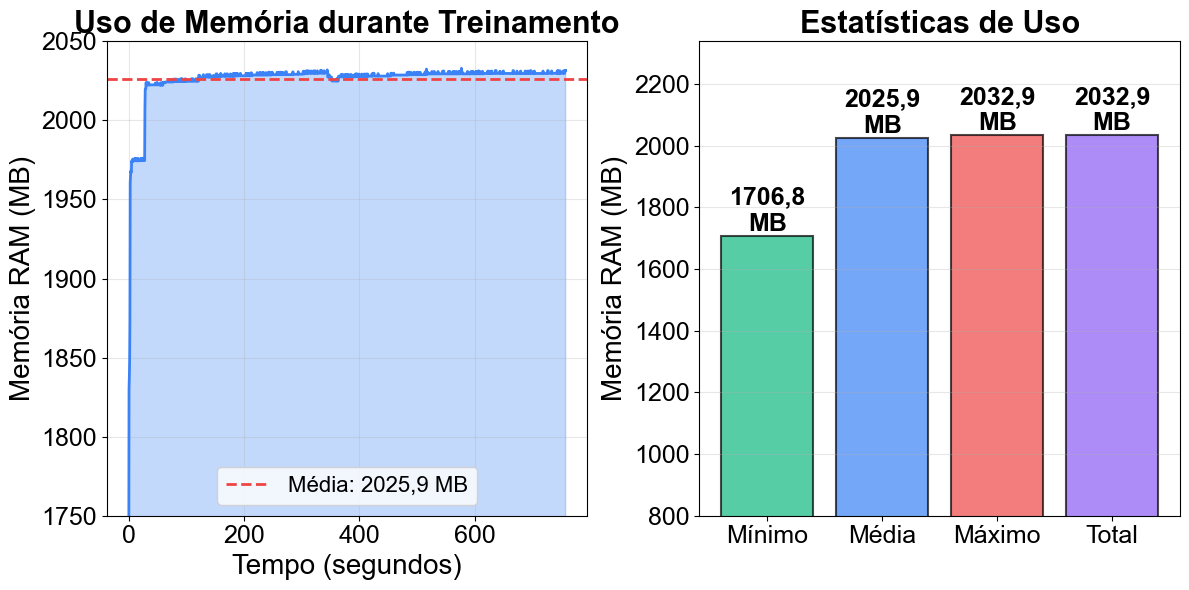

In [21]:
# Configura fonte globalmente para esta figura
plt.rcParams['font.family'] = 'Arial'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1: Evolução temporal
ax1.plot(monitor.timestamps, monitor.memory_usage, linewidth=2, color='#3b82f6')
ax1.fill_between(monitor.timestamps, monitor.memory_usage, alpha=0.3, color='#3b82f6')
ax1.set_xlabel('Tempo (segundos)', fontsize=20, family='Arial')
ax1.set_ylabel('Memória RAM (MB)', fontsize=20, family='Arial')
ax1.set_title('Uso de Memória durante Treinamento', fontsize=22, fontweight='bold', family='Arial')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=18)
ax1.set_ylim(1750, 2050)

# Adiciona linha de média
mean_memory = np.mean(monitor.memory_usage)
ax1.axhline(y=mean_memory, color='#ef4444', linestyle='--', 
            label=f'Média: {mean_memory:.1f} MB'.replace('.', ','), linewidth=2)
ax1.legend(prop={'family': 'Arial', 'size': 16})

# Gráfico 2: Estatísticas
stats = {
    'Mínimo': np.min(monitor.memory_usage),
    'Média': mean_memory,
    'Máximo': np.max(monitor.memory_usage),
    'Total': np.max(monitor.memory_usage)
}

colors = ['#10b981', '#3b82f6', '#ef4444', '#8b5cf6']
bars = ax2.bar(stats.keys(), stats.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Adiciona valores em cima das barras (com vírgula como separador decimal)
for bar, value in zip(bars, stats.values()):
    height = bar.get_height()
    valor_formatado = f'{value:.1f}'.replace('.', ',')  # <<< AQUI
    ax2.text(
        bar.get_x() + bar.get_width() / 2., height,
        f'{valor_formatado}\nMB',
        ha='center', va='bottom', fontsize=18, fontweight='bold', family='Arial'
    )

ax2.set_ylabel('Memória RAM (MB)', fontsize=20, family='Arial')
ax2.set_title('Estatísticas de Uso', fontsize=22, fontweight='bold', family='Arial')
ax2.grid(True, axis='y', alpha=0.3)
ax2.tick_params(axis='both', labelsize=18)

# Ajusta limites do eixo Y para dar espaço aos rótulos
max_val = max(stats.values())
ax2.set_ylim(800, max_val * 1.15)  # 15% de margem no topo

plt.tight_layout()
plt.savefig('resultados/centralizado_consumo_memoria.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Gráficos de Convergência

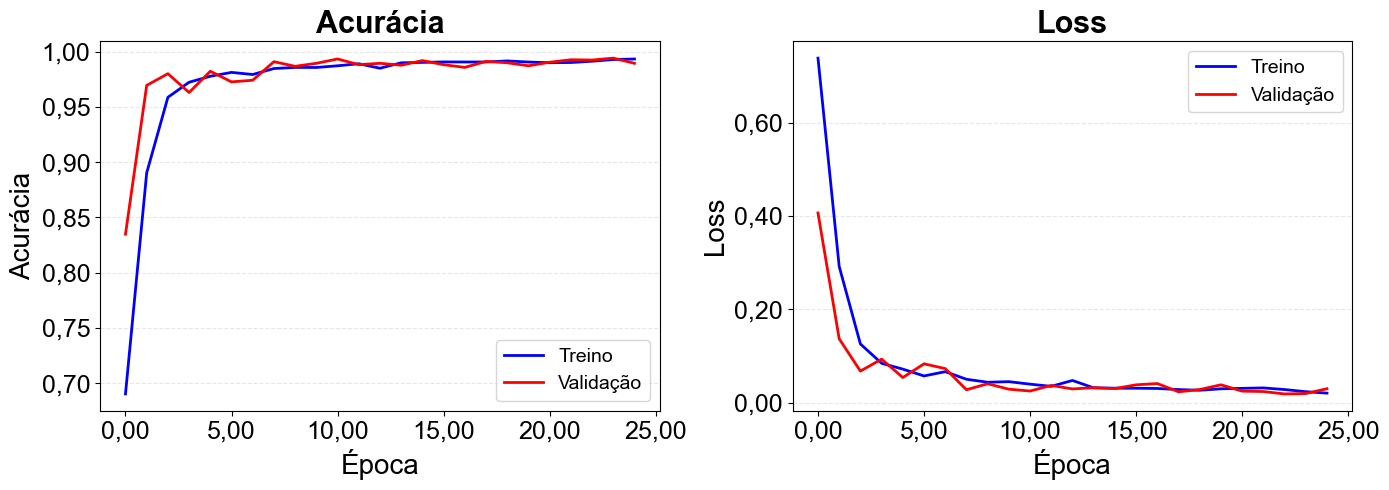

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --------------------------
# Função para trocar . por ,
# --------------------------
def virgula(x, pos):
    """Formata ticks usando vírgula como separador decimal."""
    s = f'{x:.2f}'
    return s.replace('.', ',')

formatter = FuncFormatter(virgula)

# Definir fonte Arial
plt.rcParams['font.family'] = 'Arial'

# Plotar acurácia e loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------------------------------
# Acurácia
# ------------------------------------------------------
ax1.plot(history.history['accuracy'], 'b-', linewidth=2, label='Treino')
ax1.plot(history.history['val_accuracy'], 'r-', linewidth=2, label='Validação')
ax1.set_xlabel('Época', fontsize=20)
ax1.set_ylabel('Acurácia', fontsize=20)
ax1.set_title('Acurácia', fontsize=22, fontweight='bold')
ax1.legend(fontsize=14, loc='lower right')
ax1.grid(True, axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(axis='both', labelsize=18)
ax1.yaxis.set_major_formatter(formatter)   # <<< AQUI
ax1.xaxis.set_major_formatter(formatter)   # <<< AQUI (opcional)

# ------------------------------------------------------
# Loss
# ------------------------------------------------------
ax2.plot(history.history['loss'], 'b-', linewidth=2, label='Treino')
ax2.plot(history.history['val_loss'], 'r-', linewidth=2, label='Validação')
ax2.set_xlabel('Época', fontsize=20)
ax2.set_ylabel('Loss', fontsize=20)
ax2.set_title('Loss', fontsize=22, fontweight='bold')
ax2.legend(fontsize=14)
ax2.grid(True, axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(axis='both', labelsize=18)
ax2.yaxis.set_major_formatter(formatter)   # <<< AQUI
ax2.xaxis.set_major_formatter(formatter)   # <<< AQUI (opcional)
#ax2.set_ylim(0, 2)

plt.tight_layout()
plt.savefig('resultados/centralizado_convergencia.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Avaliar no Conjunto de Teste

In [10]:
# Avaliar no teste
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n{'='*50}")
print(f"RESULTADOS NO CONJUNTO DE TESTE")
print(f"{'='*50}")
print(f"  Acurácia: {test_accuracy*100:.2f}%")
print(f"  Loss:     {test_loss:.4f}")
print(f"{'='*50}")


RESULTADOS NO CONJUNTO DE TESTE
  Acurácia: 98.91%
  Loss:     0.0331


## 8. Matriz de Confusão

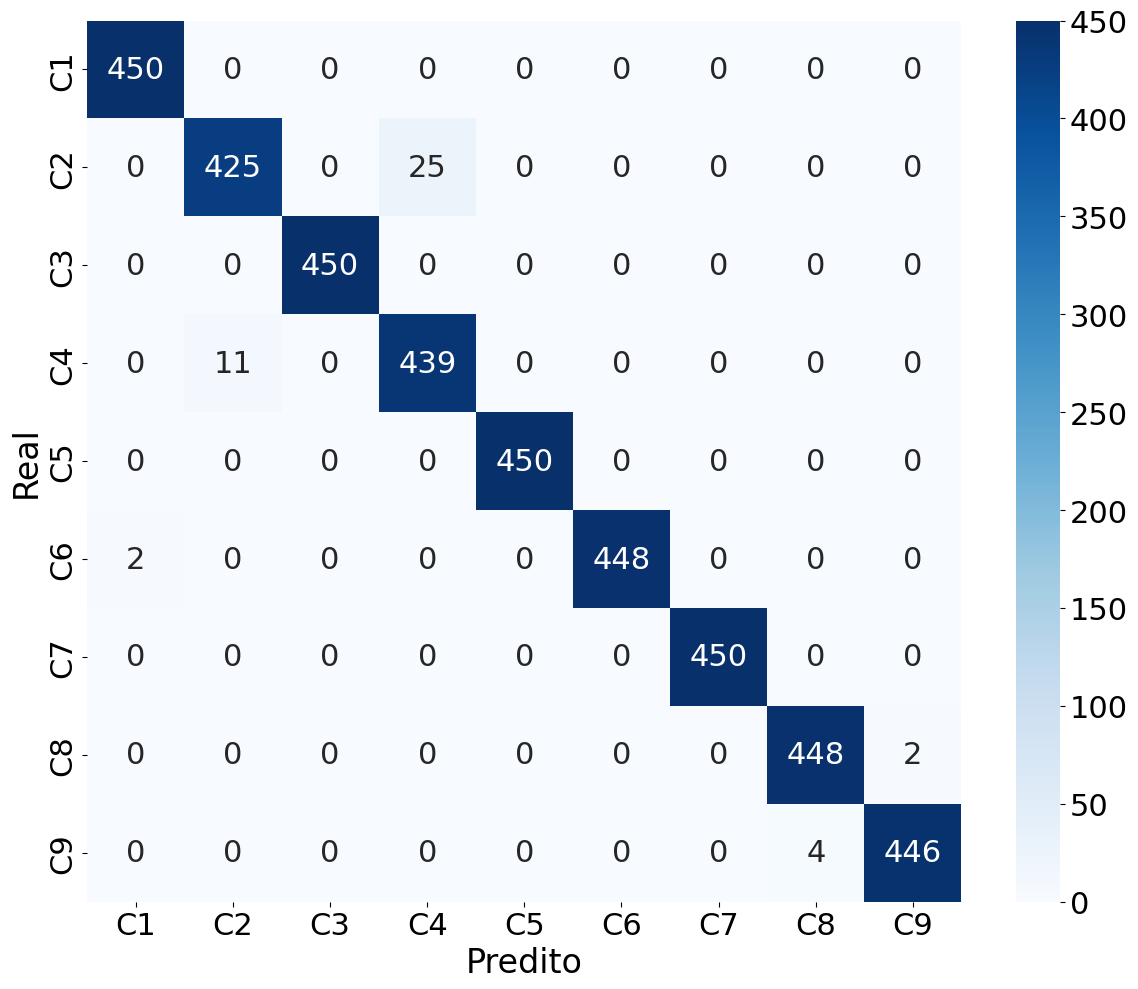

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

plt.rcdefaults()
sns.reset_defaults()

# Predições
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=[f'C{i+1}' for i in range(len(class_names))],
    yticklabels=[f'C{i+1}' for i in range(len(class_names))],
    annot_kws={"size": 22}  # valores internos
)

# Ticks dos eixos X e Y
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Aumentar o eixo auxiliar (colorbar)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

plt.xlabel('Predito', fontsize=24)
plt.ylabel('Real', fontsize=24)
#plt.title('Matriz de Confusão', fontsize=22, fontweight='bold')

plt.tight_layout()
plt.savefig('resultados/centralizado_matriz_confusao.png', dpi=150, bbox_inches='tight')
plt.show()


In [12]:
cm

array([[450,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 425,   0,  25,   0,   0,   0,   0,   0],
       [  0,   0, 450,   0,   0,   0,   0,   0,   0],
       [  0,  11,   0, 439,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 450,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0, 448,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 450,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 448,   2],
       [  0,   0,   0,   0,   0,   0,   0,   4, 446]])

In [13]:
# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_classes, 
                           target_names=[f'C{i+1}' for i in range(len(class_names))]))


Relatório de Classificação:
              precision    recall  f1-score   support

          C1       1.00      1.00      1.00       450
          C2       0.97      0.94      0.96       450
          C3       1.00      1.00      1.00       450
          C4       0.95      0.98      0.96       450
          C5       1.00      1.00      1.00       450
          C6       1.00      1.00      1.00       450
          C7       1.00      1.00      1.00       450
          C8       0.99      1.00      0.99       450
          C9       1.00      0.99      0.99       450

    accuracy                           0.99      4050
   macro avg       0.99      0.99      0.99      4050
weighted avg       0.99      0.99      0.99      4050



## 9. Salvar Modelo

In [14]:
# Salvar modelo
model.save('dataset/cnn_model.h5')
print("Modelo salvo em: dataset/cnn_model.h5")

Modelo salvo em: dataset/cnn_model.h5


## 10. Resumo Final

In [15]:
print(f"\n{'='*50}")
print(f"RESUMO DO TREINAMENTO")
print(f"{'='*50}")
print(f"\nArquitetura: CNN 1D")
print(f"Épocas: 25")
print(f"Batch size: 32")
print(f"\nDivisão dos dados:")
print(f"  Treino:     70% ({X_train.shape[0]} amostras)")
print(f"  Validação:  15% ({X_val.shape[0]} amostras)")
print(f"  Teste:      15% ({X_test.shape[0]} amostras)")
print(f"\nResultados finais:")
print(f"  Acurácia de treino:    {history.history['accuracy'][-1]*100:.2f}%")
print(f"  Acurácia de validação: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"  Acurácia de teste:     {test_accuracy*100:.2f}%")
print(f"\nArquivos gerados:")
print(f"  • convergencia.png")
print(f"  • matriz_confusao.png")
print(f"  • cnn_model.h5")
print(f"\n{'='*50}")


RESUMO DO TREINAMENTO

Arquitetura: CNN 1D
Épocas: 25
Batch size: 32

Divisão dos dados:
  Treino:     70% (18900 amostras)
  Validação:  15% (4050 amostras)
  Teste:      15% (4050 amostras)

Resultados finais:
  Acurácia de treino:    99.33%
  Acurácia de validação: 98.94%
  Acurácia de teste:     98.91%

Arquivos gerados:
  • convergencia.png
  • matriz_confusao.png
  • cnn_model.h5



# 11. SHAP

In [16]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle
# from pathlib import Path
# from sklearn.model_selection import train_test_split

# # -------------------------
# # CONFIG
# # -------------------------
# from matplotlib.ticker import FuncFormatter

# def virgula(x, pos):
#     """Formata ticks com vírgula como separador decimal."""
#     s = f'{x:.2f}'
#     return s.replace('.', ',')
    
# formatter = FuncFormatter(virgula)


# bg_size = 200
# rng = np.random.default_rng(42)
# output_dir = Path('shap')
# output_dir.mkdir(exist_ok=True)

# # -------------------------
# # Carregar dataset ORIGINAL
# # -------------------------
# print("Carregando dataset original...")
# with open('dataset/complete_dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
#     class_names = dataset['class_names']

# X = dataset['signals']
# y = dataset['labels']

# # Mesma divisão do treinamento
# X_train_orig, X_temp, y_train_orig, y_temp = train_test_split(
#     X, y, test_size=0.30, random_state=42, stratify=y
# )
# X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
#     X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
# )

# print(f"Dados originais carregados: {len(X_test_orig)} amostras de teste")

# # -------------------------
# # Preparar background para SHAP
# # -------------------------
# n_train = X_train.shape[0]
# bg_size = min(bg_size, n_train)
# bg_idx = rng.choice(n_train, size=bg_size, replace=False)
# background = X_train[bg_idx].astype(np.float32)

# # -------------------------
# # Criar explainer
# # -------------------------
# print("\nCriando SHAP explainer...")
# explainer = shap.DeepExplainer(model, background)
# print("Explainer criado com sucesso!")

# # -------------------------
# # Gerar SHAP para uma amostra de cada classe
# # -------------------------
# print(f"\nGerando explicações SHAP para {len(class_names)} classes...\n")

# for class_idx, class_name in enumerate(class_names):
#     print(f"Processando classe {class_idx+1}/{len(class_names)}: {class_name}")
    
#     # Encontrar amostras desta classe no conjunto de teste
#     class_test_indices = np.where(y_test_orig == class_idx)[0]
    
#     if len(class_test_indices) == 0:
#         print(f"  ⚠️  Nenhuma amostra encontrada para {class_name}")
#         continue
    
#     # Escolher primeira amostra desta classe
#     sample_idx = class_test_indices[0]
    
#     # Sinal original e normalizado
#     signal_original = X_test_orig[sample_idx]
#     signal_normalized = X_test[sample_idx:sample_idx+1].astype(np.float32)
    
#     # Calcular SHAP values
#     shap_values = explainer.shap_values(signal_normalized)
    
#     # DEBUG: Verificar formato do SHAP
#     if class_idx == 0:  # Printar apenas na primeira iteração
#         print(f"\n  DEBUG - Formato SHAP:")
#         print(f"    Tipo: {type(shap_values)}")
#         if isinstance(shap_values, list):
#             print(f"    Lista com {len(shap_values)} elementos")
#             print(f"    Shape de cada elemento: {shap_values[0].shape}")
#         else:
#             print(f"    Array shape: {shap_values.shape}")
    
#     # Predição
#     pred_probs = model.predict(signal_normalized, verbose=0)
#     pred_class = int(np.argmax(pred_probs))
#     pred_prob = pred_probs[0, pred_class]
    
#     # Extrair SHAP values CORRETAMENTE
#     signal_1d = signal_original.flatten()
    
#     if isinstance(shap_values, list):
#         # FORMATO 1: shap_values é uma lista [classe0, classe1, ...]
#         sv = shap_values[pred_class]
#         shap_1d = sv.reshape(-1)
#     elif shap_values.ndim == 4:
#         # FORMATO 2: shap_values shape (batch, timesteps, channels, classes)
#         # Extrair: [0, :, 0, pred_class] -> pegar classe prevista da última dimensão
#         shap_1d = shap_values[0, :, 0, pred_class]
#         if class_idx < 3:  # Mostrar apenas nas primeiras classes
#             print(f"  ✓ Extraído SHAP da classe {pred_class} (dimensão 4D)")
#     else:
#         # FORMATO 3: Array concatenado linearmente
#         shap_flat = shap_values.flatten()
#         total_len = len(shap_flat)
#         signal_len = len(signal_1d)
        
#         if total_len % signal_len == 0:
#             n_classes = total_len // signal_len
#             start_idx = pred_class * signal_len
#             end_idx = (pred_class + 1) * signal_len
#             shap_1d = shap_flat[start_idx:end_idx]
#             if class_idx < 3:
#                 print(f"  ⚠️ Array concatenado: extraindo índices {start_idx} a {end_idx}")
#         else:
#             shap_1d = shap_flat[:signal_len]
#             print(f"  ⚠️ Usando primeiros {signal_len} valores")
    
#     # -------------------------
#     # Plotar
#     # -------------------------
#     fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
    
#     # Sinal Original
#     ax1.plot(signal_1d, 'b-', linewidth=2)
#     ax1.set_title(f'Classe {class_name[0:2]} | Sinal Original', 
#                   fontsize=20, fontweight='bold')
#     ax1.set_ylabel('Amplitude', fontsize=20)
#     ax1.grid(True, alpha=0.3)
#     ax1.set_ylim([signal_1d.min()*1.1, signal_1d.max()*1.1])
#     ax1.tick_params(axis='both', labelsize=18)
#     ax1.yaxis.set_major_formatter(formatter)
#     ax1.xaxis.set_major_formatter(formatter)

#     # Indicar se a predição está correta
#     is_correct = (pred_class == class_idx)
#     status = "CORRETO" if is_correct else f"ERRO (previu: {class_names[pred_class]})"
#     color = 'green' if is_correct else 'red'
    
#     # SHAP values
#     ax2.plot(shap_1d, 'r-', linewidth=2)
#     ax2.set_title(f'SHAP | Predição: {class_names[pred_class][0:2]} ({pred_prob:.0%}) - {status}', 
#                   fontsize=20, fontweight='bold', color=color)
#     ax2.set_ylabel('Valor SHAP', fontsize=20)
#     ax2.grid(True, alpha=0.3)
#     ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
#     ax2.tick_params(axis='both', labelsize=18)
#     ax2.yaxis.set_major_formatter(formatter)
#     ax2.xaxis.set_major_formatter(formatter)

#     # Overlay
#     signal_norm_plot = (signal_1d - signal_1d.mean()) / signal_1d.std()
#     shap_norm_plot = shap_1d / np.abs(shap_1d).max() * signal_norm_plot.std()
    
#     x_axis = np.arange(len(signal_norm_plot))
    
#     ax3.plot(x_axis, signal_norm_plot, 'b-', linewidth=2, alpha=0.7, label='Sinal')
#     ax3.plot(x_axis, shap_norm_plot, 'r-', linewidth=2, alpha=0.7, label='SHAP')
#     ax3.fill_between(x_axis, 0, shap_norm_plot, alpha=0.3, color='red')
#     ax3.set_title('Sobreposição: Sinal + SHAP (normalizados)', 
#                   fontsize=20, fontweight='bold')
#     ax3.set_xlabel('Tempo (ms)', fontsize=20)
#     ax3.set_ylabel('Amplitude', fontsize=20)
#     #ax3.legend(fontsize=16)
#     ax3.grid(True, alpha=0.3)
#     ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
#     ax3.tick_params(axis='both', labelsize=18)
#     ax3.yaxis.set_major_formatter(formatter)
#     ax3.xaxis.set_major_formatter(formatter)

#     plt.tight_layout()
    
#     # Salvar
#     filename = f'centralizado_shap_classe_{class_name}.png'
#     filepath = output_dir / filename
#     plt.savefig(filepath, dpi=150, bbox_inches='tight')
#     plt.close()
    
#     print(f"  ✓ Salvo: {filename}")

# print(f"\n{'='*60}")
# print(f"CONCLUÍDO!")
# print(f"{'='*60}")
# print(f"\nTodas as explicações SHAP foram salvas em: {output_dir}/")
# print(f"Total de arquivos gerados: {len(list(output_dir.glob('*.png')))}")
# print(f"\nArquivos:")
# for f in sorted(output_dir.glob('*.png')):
#     print(f"  • {f.name}")

In [17]:
# import shap
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # -------------------------
# # CONFIG
# # -------------------------
# from matplotlib.ticker import FuncFormatter

# def virgula(x, pos):
#     """Formata ticks com vírgula como separador decimal."""
#     s = f'{x:.2f}'
#     return s.replace('.', ',')
    
# formatter = FuncFormatter(virgula)

# bg_size = 200
# rng = np.random.default_rng(42)
# output_dir = Path('shap')
# output_dir.mkdir(exist_ok=True)

# # -------------------------
# # 1. Carregar dataset ORIGINAL
# # -------------------------
# print("Carregando dataset original...")
# with open('dataset/complete_dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
#     class_names = dataset['class_names']

# X_original = dataset['signals']
# y = dataset['labels']

# print(f"✓ Shape original dos dados: {X_original.shape}")
# print(f"✓ Total de amostras: {len(X_original)}")

# # -------------------------
# # 2. Dividir dados (MESMA divisão do treinamento)
# # -------------------------
# X_train_orig, X_temp_orig, y_train, y_temp = train_test_split(
#     X_original, y, test_size=0.30, random_state=42, stratify=y
# )
# X_val_orig, X_test_orig, y_val, y_test = train_test_split(
#     X_temp_orig, y_temp, test_size=0.50, random_state=42, stratify=y_temp
# )

# print(f"✓ Train: {X_train_orig.shape} | Test: {X_test_orig.shape}")

# # -------------------------
# # 3. Normalizar dados PRESERVANDO SHAPE (timesteps, channels)
# # -------------------------
# print("\n🔧 Normalizando dados (preservando shape)...")

# # ✅ CORREÇÃO: Manter dimensão do canal durante normalização
# if X_train_orig.ndim == 3:
#     # Shape: (samples, timesteps, channels)
#     n_samples_train, n_timesteps, n_channels = X_train_orig.shape
#     n_samples_test = X_test_orig.shape[0]
    
#     # Reshape para (samples * timesteps, channels) para normalizar
#     X_train_reshaped = X_train_orig.reshape(-1, n_channels)
#     X_test_reshaped = X_test_orig.reshape(-1, n_channels)
    
#     # Normalizar
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train_reshaped)
#     X_test_scaled = scaler.transform(X_test_reshaped)
    
#     # ✅ IMPORTANTE: Reshape de volta para (samples, timesteps, channels)
#     X_train_norm = X_train_scaled.reshape(n_samples_train, n_timesteps, n_channels)
#     X_test_norm = X_test_scaled.reshape(n_samples_test, n_timesteps, n_channels)
    
# elif X_train_orig.ndim == 2:
#     # Shape: (samples, timesteps) - adicionar dimensão do canal
#     scaler = StandardScaler()
#     X_train_norm = scaler.fit_transform(X_train_orig)
#     X_test_norm = scaler.transform(X_test_orig)
    
#     # ✅ Adicionar dimensão do canal: (samples, timesteps) -> (samples, timesteps, 1)
#     X_train_norm = X_train_norm[..., np.newaxis]
#     X_test_norm = X_test_norm[..., np.newaxis]
    
# else:
#     raise ValueError(f"Shape inesperado: {X_train_orig.shape}")

# print(f"✓ Train normalizado: {X_train_norm.shape}")
# print(f"✓ Test normalizado: {X_test_norm.shape}")
# print(f"✓ Train stats: mean={X_train_norm.mean():.4f}, std={X_train_norm.std():.4f}")

# # -------------------------
# # 4. Preparar background para SHAP
# # -------------------------
# bg_size = min(bg_size, len(X_train_norm))
# bg_idx = rng.choice(len(X_train_norm), size=bg_size, replace=False)
# background = X_train_norm[bg_idx].astype(np.float32)

# print(f"\n✓ Background: {background.shape} (deve ser 3D)")

# # -------------------------
# # 5. Carregar modelo
# # -------------------------
# print("\n📦 Carregando modelo...")
# # ⚠️ ADICIONE SEU CÓDIGO DE CARREGAMENTO AQUI
# # Exemplo:
# from tensorflow import keras
# model = keras.models.load_model('dataset/cnn_model.h5')

# try:
#     # Tentar usar modelo já carregado na memória
#     print(f"✓ Modelo encontrado: {type(model)}")
#     print(f"✓ Input shape esperado: {model.input_shape}")
    
#     # Verificar compatibilidade
#     expected_shape = model.input_shape[1:]  # Ignorar batch
#     actual_shape = X_test_norm.shape[1:]
    
#     if expected_shape != actual_shape:
#         print(f"⚠️  WARNING: Shape mismatch!")
#         print(f"   Esperado: {expected_shape}")
#         print(f"   Atual: {actual_shape}")
        
# except NameError:
#     print("❌ ERRO: Modelo não carregado!")
#     print("   Por favor, carregue seu modelo antes de continuar.")
#     raise

# # -------------------------
# # 6. Criar explainer
# # -------------------------
# print("\n🔍 Criando SHAP explainer...")
# explainer = shap.DeepExplainer(model, background)
# print("✓ Explainer criado com sucesso!")

# # -------------------------
# # 7. Gerar SHAP para uma amostra de cada classe
# # -------------------------
# print(f"\n{'='*60}")
# print(f"GERANDO EXPLICAÇÕES SHAP")
# print(f"{'='*60}\n")

# for class_idx, class_name in enumerate(class_names):
#     print(f"[{class_idx+1}/{len(class_names)}] Processando: {class_name}")
    
#     # Encontrar amostras desta classe
#     class_test_indices = np.where(y_test == class_idx)[0]
    
#     if len(class_test_indices) == 0:
#         print(f"  ⚠️  Nenhuma amostra encontrada")
#         continue
    
#     # Escolher primeira amostra
#     sample_idx = class_test_indices[0]
    
#     # ✅ CORRETO: Manter shape 3D (batch, timesteps, channels)
#     signal_original = X_test_orig[sample_idx]  # Para visualização (shape original)
#     signal_normalized = X_test_norm[sample_idx:sample_idx+1].astype(np.float32)  # Para SHAP (shape: 1, timesteps, channels)
    
#     print(f"  📊 Shapes - Original: {signal_original.shape} | Normalizado: {signal_normalized.shape}")
    
#     # Calcular SHAP values
#     try:
#         shap_values = explainer.shap_values(signal_normalized)
#     except Exception as e:
#         print(f"  ❌ Erro ao calcular SHAP: {e}")
#         continue
    
#     # DEBUG: Verificar formato APENAS na primeira vez
#     if class_idx == 0:
#         print(f"\n  📊 DEBUG - Formato SHAP:")
#         print(f"     Tipo: {type(shap_values)}")
#         if isinstance(shap_values, list):
#             print(f"     Lista com {len(shap_values)} elementos")
#             print(f"     Shape de cada: {shap_values[0].shape}")
#         else:
#             print(f"     Array shape: {shap_values.shape}\n")
    
#     # Predição
#     pred_probs = model.predict(signal_normalized, verbose=0)
#     pred_class = int(np.argmax(pred_probs))
#     pred_prob = pred_probs[0, pred_class]
    
#     # ✅ EXTRAÇÃO CORRETA DE SHAP VALUES
#     # Flatten do sinal original para plotar (1D)
#     if signal_original.ndim == 2:
#         # Shape: (timesteps, channels) -> pegar primeiro canal
#         signal_1d = signal_original[:, 0]
#     else:
#         signal_1d = signal_original.flatten()
    
#     # Extrair SHAP baseado no formato
#     if isinstance(shap_values, list):
#         # DeepExplainer retorna lista [shap_class_0, shap_class_1, ...]
#         sv = shap_values[pred_class]
#         if sv.ndim == 3:
#             # Shape: (1, timesteps, channels) -> pegar (0, :, 0)
#             shap_1d = sv[0, :, 0]
#         else:
#             shap_1d = sv.flatten()
        
#     elif shap_values.ndim == 3:
#         # Shape: (1, timesteps, channels)
#         shap_1d = shap_values[0, :, 0]
        
#     elif shap_values.ndim == 4:
#         # Shape: (1, timesteps, channels, num_classes)
#         shap_1d = shap_values[0, :, 0, pred_class]
        
#     else:
#         shap_1d = shap_values.flatten()
#         print(f"  ⚠️  Shape inesperado: {shap_values.shape}")
    
#     # Garantir que comprimentos batem
#     if len(shap_1d) != len(signal_1d):
#         print(f"  ⚠️  Ajustando tamanhos: signal={len(signal_1d)}, shap={len(shap_1d)}")
#         min_len = min(len(signal_1d), len(shap_1d))
#         signal_1d = signal_1d[:min_len]
#         shap_1d = shap_1d[:min_len]
    
#     # -------------------------
#     # 8. Plotar
#     # -------------------------
#     fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
    
#     # Painel 1: Sinal Original
#     ax1.plot(signal_1d, 'b-', linewidth=2)
#     ax1.set_title(f'Classe {class_name[:2]} | Sinal Original', 
#                   fontsize=20, fontweight='bold')
#     ax1.set_ylabel('Amplitude', fontsize=20)
#     ax1.grid(True, alpha=0.3)
#     ax1.set_ylim([signal_1d.min()*1.1, signal_1d.max()*1.1])
#     ax1.tick_params(axis='both', labelsize=18)
#     ax1.yaxis.set_major_formatter(formatter)
#     ax1.xaxis.set_major_formatter(formatter)

#     # Status da predição
#     is_correct = (pred_class == class_idx)
#     status = "CORRETO" if is_correct else f"ERRO (previu: {class_names[pred_class]})"
#     color = 'green' if is_correct else 'red'
    
#     # Painel 2: SHAP values
#     ax2.plot(shap_1d, 'r-', linewidth=2)
#     ax2.set_title(f'SHAP | Predição: {class_names[pred_class][:2]} ({pred_prob:.0%}) - {status}', 
#                   fontsize=20, fontweight='bold', color=color)
#     ax2.set_ylabel('Valor SHAP', fontsize=20)
#     ax2.grid(True, alpha=0.3)
#     ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
#     ax2.tick_params(axis='both', labelsize=18)
#     ax2.yaxis.set_major_formatter(formatter)
#     ax2.xaxis.set_major_formatter(formatter)

#     # Painel 3: Overlay
#     signal_norm_plot = (signal_1d - signal_1d.mean()) / (signal_1d.std() + 1e-8)
    
#     shap_max = np.abs(shap_1d).max()
#     if shap_max > 0:
#         shap_norm_plot = shap_1d / shap_max * signal_norm_plot.std()
#     else:
#         shap_norm_plot = shap_1d
    
#     x_axis = np.arange(len(signal_norm_plot))
    
#     ax3.plot(x_axis, signal_norm_plot, 'b-', linewidth=2, alpha=0.7, label='Sinal')
#     ax3.plot(x_axis, shap_norm_plot, 'r-', linewidth=2, alpha=0.7, label='SHAP')
#     ax3.fill_between(x_axis, 0, shap_norm_plot, alpha=0.3, color='red')
#     ax3.set_title('Sobreposição: Sinal + SHAP (normalizados)', 
#                   fontsize=20, fontweight='bold')
#     ax3.set_xlabel('Tempo (ms)', fontsize=20)
#     ax3.set_ylabel('Amplitude', fontsize=20)
#     ax3.legend(fontsize=16, loc='upper right')
#     ax3.grid(True, alpha=0.3)
#     ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
#     ax3.tick_params(axis='both', labelsize=18)
#     ax3.yaxis.set_major_formatter(formatter)
#     ax3.xaxis.set_major_formatter(formatter)

#     plt.tight_layout()
    
#     # Salvar
#     filename = f'shap_centralizado_classe_{class_name}.png'
#     filepath = output_dir / filename
#     plt.savefig(filepath, dpi=150, bbox_inches='tight')
#     plt.close()
    
#     print(f"  ✓ Salvo: {filename}\n")

# print(f"{'='*60}")
# print(f"✅ CONCLUÍDO!")
# print(f"{'='*60}")
# print(f"\nArquivos salvos em: {output_dir}/")
# print(f"Total: {len(list(output_dir.glob('*.png')))} imagens")